# Interview Case - MP Data

Objectif : Fournir un classifier permettant de prédire qu’un joueur vaut le coup 
d’investir sur lui car il va durer plus de 5 ans en NBA 
en s’appuyant sur ses statistiques sportives.

## Explication Projet Global

1) Tout d'abord, j'ai effectué une recherche pour trouver le meilleur modèle dans notre cas.
2) Après avoir trouvé, j'ai cherché à l'améliorer et à modifier son seuil, pour en maximiser la précision.
3) J'ai ensuite crée une image Docker de l'ensemble afin de l'utiliser sous la forme d'une API, mis à disposition sur GCPlateform
4) Enfin, j'ai mis en place un Streamlit simple permettant de requeter l'API et d'afficher si les statistiques du joueur entrées par l'utilisateur peuvent permettre de miser sur lui ou non.

## Explication Choix

- Choix Precision    
J'ai décidé de choisir la précision, car pour moi il est intéressant de miser avec "précision" sur les joueurs, c'est à dire d'être sur qu'en misant sur un joueur,   
il jouera pendant au moins 5 ans, et a contrario de "rater" des pépites qui jouerait encore dans 5 ans. J'ai pris le parti qu'un club préfère être sur de ses recrues, quitte a en rater des bonnes, plutôt que d'en faire entrer plus et d'avoir des déceptions.


- Choix Modèle :
Après Grid Search, et optimsation des modèles, on remarque que dans l'état actuel, le plus intéresant est le modèle de Logistique Regression.

* Objectif :    
Trouver le seuil de la Logistique Regression minimale afin que le selectionneur de NBA puisse connaitre à 90% de precision près, si un joueur qu'il sélectionne sera encore là dans 5 ans ou non.

## Importations

In [3]:
%load_ext autoreload
%matplotlib inline

#%run <file name>
#%who

In [4]:
#General
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#SkLearn
#Scalers
from sklearn.preprocessing import MinMaxScaler, RobustScaler
#Models
from sklearn.linear_model import LogisticRegression

#Autre
from sklearn.model_selection import train_test_split,cross_validate
from test_precision import score_classifier_precision,score_classifier_precision_90
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve

## Test Basic test.py

In [5]:
%run test.py

[[271. 238.]
 [145. 686.]]
Recall= 0.82551959002102


In [6]:
%run test_precision.py

[[271. 238.]
 [145. 686.]]
Precision= 0.7426951153127018


## Analyse Data

### Première Analyse/Pre-PreProc

In [7]:
#On récupère le fichier csv des données
data = pd.read_csv("data/nba_logreg.csv")
data.head()

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0


In [8]:
#On regarde les duplictes et on les supprime
print(data.duplicated().sum(),"duplicates avant drop_dupli")
data = data.drop_duplicates()
print(data.duplicated().sum(),"duplicates après drop_dupli")

12 duplicates avant drop_dupli
0 duplicates après drop_dupli


In [9]:
#On reset index après suppression des duplicates
data.reset_index(drop=True,inplace=True)

In [10]:
# Après analyse, le fait de modifier le dataset influence négativement les métrics
# On garde donc le dataset initial
data.TARGET_5Yrs.value_counts(normalize=True)

1.0    0.620482
0.0    0.379518
Name: TARGET_5Yrs, dtype: float64

In [11]:
## Manière pour équilibrer le dataset 50/50 si besoin
# data_0 = data[data['TARGET_5Yrs']==0]
# data_1 = data[data['TARGET_5Yrs']==1].sample(504)
# data = pd.concat([data_0,data_1],axis=0).sample(frac=1)
# data

On récupère la colonne de "Name" qui n'est pas intéressante pour notre analyse

In [12]:
names = data[['Name']] # players names
names.isna().sum() # Pas de Nan dans les noms

Name    0
dtype: int64

In [13]:
#On récupère la donnée
X = data.drop(columns=['TARGET_5Yrs','Name'])

In [14]:
#On a remplacé les nan de joueurs sans 3P réussis par 0
X[['3P%']] = X[['3P%']].fillna(0.0)
X.isna().sum()

GP         0
MIN        0
PTS        0
FGM        0
FGA        0
FG%        0
3P Made    0
3PA        0
3P%        0
FTM        0
FTA        0
FT%        0
OREB       0
DREB       0
REB        0
AST        0
STL        0
BLK        0
TOV        0
dtype: int64

In [15]:
#On récupère la target
y = data.TARGET_5Yrs.astype(int) # labels

### Scaling

In [16]:
#On utilise un MinMax Scaler
rb_scaler = MinMaxScaler()
np_scaled = rb_scaler.fit_transform(X)
X_scaled = pd.DataFrame(np_scaled, columns=X.columns)
X_scaled

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,0.352113,0.642857,0.243636,0.232323,0.357895,0.218437,0.217391,0.323077,0.250,0.207792,0.225490,0.699,0.132075,0.340426,0.279412,0.179245,0.16,0.102564,0.279070
1,0.338028,0.629630,0.236364,0.171717,0.310526,0.116232,0.304348,0.430769,0.235,0.337662,0.333333,0.765,0.094340,0.191489,0.154412,0.349057,0.44,0.128205,0.348837
2,0.887324,0.322751,0.163636,0.171717,0.205263,0.368737,0.173913,0.261538,0.244,0.116883,0.127451,0.670,0.094340,0.159574,0.139706,0.094340,0.20,0.076923,0.209302
3,0.661972,0.224868,0.181818,0.202020,0.247368,0.376754,0.043478,0.076923,0.226,0.116883,0.127451,0.689,0.188679,0.074468,0.117647,0.075472,0.24,0.025641,0.209302
4,0.521127,0.222222,0.138182,0.131313,0.115789,0.573146,0.000000,0.015385,0.000,0.168831,0.186275,0.674,0.188679,0.138298,0.161765,0.028302,0.12,0.102564,0.162791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1323,0.971831,0.335979,0.130909,0.131313,0.147368,0.390782,0.000000,0.030769,0.143,0.155844,0.147059,0.792,0.075472,0.063830,0.066176,0.235849,0.24,0.051282,0.162791
1324,0.802817,0.251323,0.116364,0.121212,0.173684,0.240481,0.043478,0.107692,0.167,0.103896,0.098039,0.794,0.075472,0.095745,0.088235,0.216981,0.32,0.000000,0.279070
1325,0.450704,0.238095,0.170909,0.191919,0.163158,0.625251,0.000000,0.000000,0.000,0.129870,0.156863,0.643,0.283019,0.223404,0.257353,0.028302,0.12,0.102564,0.186047
1326,0.577465,0.235450,0.138182,0.141414,0.157895,0.402806,0.000000,0.030769,0.100,0.155844,0.176471,0.625,0.037736,0.021277,0.029412,0.207547,0.16,0.025641,0.162791


## Mise en place du Modèle LogRegression

### Test pour connaitre ses metrics

In [17]:
LogReg_classi = LogisticRegression(max_iter=1000)
cv_result = cross_validate(LogReg_classi,X_scaled,y,cv=5,scoring=['accuracy','precision','recall','f1'])

print("Accuracy=",cv_result['test_accuracy'].mean())
print("Precision=",cv_result['test_precision'].mean())
print("Recall=",cv_result['test_recall'].mean())
print("F1=",cv_result['test_f1'].mean())

Accuracy= 0.7085657540076606
Precision= 0.7403296230283133
Recall= 0.8179379157427938
F1= 0.7766206592323581


In [18]:
score_classifier_precision(X_scaled.values,LogReg_classi,y.values,True)

[[264. 240.]
 [142. 682.]]
Precision= 0.7392574577642866


0.7392574577642866

La précision est ici trop faible, on souhaite l'augmenter à un niveau de 90% !

### Recherche du seuil pour avoir une précision de 90%

In [19]:
#On récupère les probabilités à l'aide d'un cross_val_predict, a
y_pred_probas_0, y_pred_probas_1 = cross_val_predict(LogisticRegression(max_iter=10000),
                                                     X_scaled, y,
                                                     method = "predict_proba").T

# Et on en déduit les différentes valeurs de precision, recall et threshold, dans le cas où le joueur est 'choisi'
precision, recall, thresholds = precision_recall_curve(y, y_pred_probas_1)
df_precision = pd.DataFrame({"precision" : precision[:-1], "threshold" : thresholds})
df_precision

,precision,threshold
0,0.620482,0.057969
1,0.620950,0.125969
2,0.621418,0.126084
3,0.621132,0.129832
4,0.621601,0.129902
...,...,...
1305,0.833333,0.971098
1306,0.800000,0.975302
1307,0.750000,0.978125
1308,1.000000,0.985420


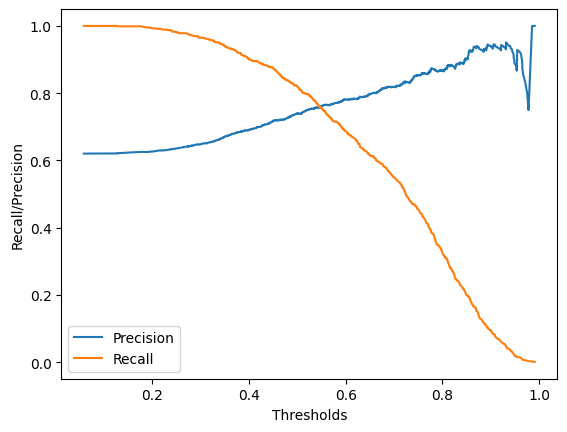

In [20]:
plt.plot(thresholds,precision[:-1],label="Precision")
plt.plot(thresholds,recall[:-1],label="Recall")
plt.xlabel("Thresholds")
plt.ylabel("Recall/Precision")
plt.legend()
plt.show()

On peut remarquerle point "optimal", si l'on souhaite que les 2 metrics (recall et precision) soient égales. Dans notre cas, on cherche plutôt la valeur de seuil pour que la précision soit de 0.9. par lecture graphique, ici à environ 0.85

In [21]:
# On cherche donc le seuil minimal pour que la précision soir supérieur à 0.9
df_precision[df_precision['precision'] >= 0.9]['threshold']
new_threshold = df_precision[df_precision['precision'] >= 0.9]['threshold'].min()

print("Le seule minimal pour que la précision soit de 90p est de",new_threshold)

Le seule minimal pour que la précision soit de 90p est de 0.8471156209655243


On utilisera une fonction de ce type au sein de l'API afin de pouvoir recalculer si le joueur en question vaut un investissement ou non, avec une précision de 90% cette fois

In [22]:

def custom_predict(nouveau_joueur_scaled,model, custom_threshold=0.8472):
    probs = model.predict_proba(nouveau_joueur_scaled) #On calcula la probabilité du nouveau joueur
    proba_1 = probs[:, 1] # Et on s'intéresse au cas où il est intéressant
    return (proba_1 > custom_threshold) #Si 1, il est assez interssant pour nous, à un précision de 90%
#Si 0, il ne l'est pas.

# Conclusion

In [23]:
score_classifier_precision_90(X_scaled.values,LogReg_classi,y.values,True)
#On obtient bien une précision de 90% avec le scorer initial.

[[487.  17.]
 [646. 178.]]
Précision= 0.9127154804574159


0.9127154804574159

Il serait intéressant de préciser l'avis du coach afin de savoir s'il souhaite prendre un peu de risque, c'est à dire moins de précision mais à contrario il pourrait espérer recruter plus de pépites (ce qui est moins le cas avec une précision élevé, le recall est du coup plus faible).

On peut donc mettre cela en ligne, à l'aide d'une API et d'un Streamlit.

# Sauvegarde du Scaleur et du Modèle LogReg

In [87]:
from pickle import dump
rb_scaler = MinMaxScaler()
np_scaled = rb_scaler.fit_transform(X)
X_scaled = pd.DataFrame(np_scaled, columns=X.columns)
X_scaled

LogReg = LogisticRegression(max_iter=1000) #On fit sur l'ensemble des données
LogReg.fit(X_scaled,y)

# save the scaler
dump(rb_scaler, open('scaler_opti.pkl', 'wb'))
# save the model
dump(LogReg, open('model_reglog_opti.pkl', 'wb'))